In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')

#Visulization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Machine Learning
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.linear_model import LogisticRegression

#Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

#HyperParameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# F2 score for gridSearchCV
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

In [2]:
t_data = pd.read_csv(r'C:\Users\김상휘\Desktop\Hwi\한이음-kt\data\telecom_data.csv', encoding='euc-kr',engine='python')
t_data.rename(columns= t_data.iloc[0],inplace=True)
t_data.drop(t_data.index[0],axis=0,inplace=True)

#### 전처리

In [3]:
#결측치 처리
t_data['TotalCharges'] = t_data['TotalCharges'].replace(" ",np.nan)
t_data.dropna(inplace=True)
t_data.drop('customerID',axis=1,inplace=True)

#타입 변경
col1 = ['MonthlyCharges','TotalCharges']
for i in col1:
    t_data[i] = t_data[i].astype(float)

t_data['tenure'] = t_data['tenure'].astype(int)
t_data.dtypes

#이탈 여부 표현
t_data.loc[t_data.Churn == 'No','Churn'] = 0
t_data.loc[t_data.Churn == 'Yes', 'Churn'] = 1
t_data.Churn = t_data.Churn.astype(int)

#### 가정) Monthly Charge와 Total Charge 값의 단위를 만원으로 나타내기 위해 10으로 나눠줌

In [4]:
t_data['MonthlyCharges'] = t_data['MonthlyCharges']/10
t_data['TotalCharges'] = t_data['TotalCharges']/10

#### 집단 4개로 나누기 - 중간값 기준

In [5]:
group_1 = t_data[(t_data['MonthlyCharges'] < t_data['MonthlyCharges'].median()) & (t_data['tenure'] < t_data['tenure'].median())]
group_2 = t_data[(t_data['MonthlyCharges'] < t_data['MonthlyCharges'].median()) & (t_data['tenure'] > t_data['tenure'].median())]
group_3 = t_data[(t_data['MonthlyCharges'] > t_data['MonthlyCharges'].median()) & (t_data['tenure'] < t_data['tenure'].median())]
group_4 = t_data[(t_data['MonthlyCharges'] > t_data['MonthlyCharges'].median()) & (t_data['tenure'] > t_data['tenure'].median())]

group = [group_1,group_2,group_3,group_4]

print('그룹 1 : 낮은 요금제, 짧은 임기')
print('그룹 2 : 낮은 요금제, 긴 임기')
print('그룹 3 : 높은 요금제, 짧은 임기')
print('그룹 4 : 높은 요금제, 긴 임기')

그룹 1 : 낮은 요금제, 짧은 임기
그룹 2 : 낮은 요금제, 긴 임기
그룹 3 : 높은 요금제, 짧은 임기
그룹 4 : 높은 요금제, 긴 임기


In [6]:
# 이름 출력을 위한 함수
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

# 해당 집단의 평균 사용 요금제, 임기, 사람 수
def group_info(data):
    print('name : {}'.format(namestr(data, globals())[0]))
    print('average monthly charge : {:.5f}'.format(data['MonthlyCharges'].mean()))
    print('average tenure : {:.5f}'.format(data['tenure'].mean()))
    print('number of people : {}\n'.format(data.shape[0]))
    return round(data['MonthlyCharges'].mean(),5), round(data['tenure'].mean(),5), data.shape[0]

In [7]:
group1_MC, group1_TN, group1_num = group_info(group_1)
group2_MC, group2_TN, group2_num = group_info(group_2)
group3_MC, group3_TN, group3_num = group_info(group_3)
group4_MC, group4_TN, group4_num = group_info(group_4)

name : group_1
average monthly charge : 3.90229
average tenure : 9.83839
number of people : 2042

name : group_2
average monthly charge : 3.88353
average tenure : 52.99790
number of people : 1430

name : group_3
average monthly charge : 8.55252
average tenure : 11.52884
number of people : 1439

name : group_4
average monthly charge : 9.42872
average tenure : 55.49853
number of people : 2040



#### 각 집단별 최적의 재현율과 정밀도 찾기

- 재현율 오류에 대한 손해 : (데이터 수 * (1-재현율)) * (mothly charge * tenure)
- 정밀도 오류에 대한 손해 : (mothly charge * tenure) = (데이터 수 * (1-정밀도)) * 1인당 투자하는 솔루션 비용

- total loss가 가장 적은 지점이 최고 성능, diff loss=0 인 구간이 손익분기점

In [8]:
def loss_point(num, charge, tenure, sol_price, recall, precision):
    recall_loss = round(((num*(1-recall))*(charge*tenure)),5)
    precision_loss = round(((num*(1-precision))*sol_price),5)
    diff_loss = (recall_loss - precision_loss)
    total_loss = (recall_loss + precision_loss)
    
    if diff_loss > 0:
        print('재현율을 더 높여야 합니다.')
        print('재현율 오류에 따른 손해 : {}만원'.format(recall_loss))
        print('정밀도 오류에 따른 손해 : {}만원'.format(precision_loss))
        print('차이 : {:.5f}만원'.format(diff_loss))
    elif diff_loss < 0:
        print('정밀도를 더 높여야 합니다.')
        print('재현율 오류에 따른 손해 : {}만원'.format(recall_loss))
        print('정밀도 오류에 따른 손해 : {}만원'.format(precision_loss))
        print('차이 : {:.5f}'.format(abs(diff_loss)))
    elif diff_loss == 0:
        print('현재 손익분기점 입니다.')
        
    return diff_loss, total_loss

#### One hot encoding

In [9]:
def OHE(data):
    t_data_dummies = data.drop('Churn',axis=1)
    t_data_dummies = pd.get_dummies(t_data_dummies)
    t_data_dummies['Churn'] = data['Churn']
    return t_data_dummies

group_1 = OHE(group_1)
group_2 = OHE(group_2)
group_3 = OHE(group_3)
group_4 = OHE(group_4)

## 모델링

In [10]:
model_box = pd.DataFrame(columns=['logistic','xgboost','lightgbm','catboost'],
                         index = ['accuracy','precision','recall','f1 score','f1.5 score','f2 score','pr_auc','roc_auc'])

In [11]:
def f_score(beta,y_real, y_pred):
    beta = beta
    pr = precision_score(y_real, y_pred)
    re = recall_score(y_real, y_pred)
    score = (1+beta**2)*(pr*re)/((beta**2*pr)+re)
    return score

In [12]:
def evaluate(y_real,y_pred, y_prob):
    acc = accuracy_score(y_real, y_pred)
    pre = precision_score(y_real, y_pred)
    rec = recall_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred)
    f2 = f_score(1.5,y_real, y_pred)
    f3 = f_score(2,y_real, y_pred)
    auc1 = average_precision_score(y_real, y_prob)
    auc2 = roc_auc_score(y_real, y_prob)
    
    print('Accuracy : {:.6f}'.format(acc)) #정확도 : 예측이 정답과 얼마나 정확한가
    print('Precision : {:.6f}'.format(pre)) #정밀도 : 예측한 것 중에서 정답의 비율
    print('Recall : {:.6f}'.format(rec)) #재현율 : 정답 중에서 예측한 것의 비율
    print('F1 score : {:.6f}'.format(f1)) #정밀도와 재현율의 (조화)평균 - 정밀도와 재현율이 비슷할수록 높은 점수
    print('F1.5 score : {:.6f}'.format(f2))
    print('F2 score : {:.6f}'.format(f3))
    print('PR curve_auc score : {:.6f}'.format(auc1))
    print('ROC curve_auc score : {:.6f}'.format(auc2))
    print('\nConfusion Matrix : \n {}'.format(confusion_matrix(y_real, y_pred, labels = [1,0]))) # labels를 설정해주지 않으면 순서가 바뀜
    score_list = [acc,pre,rec,f1,f2,f3,auc1,auc2]
    score_box = np.array(score_list)
    return score_box

In [13]:
def precision_recall_thresholds(y_val, y_prob):
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)
    plt.figure(figsize = (15,5))
    plt.plot(thresholds, recalls[:-1], color = 'red', label = 'recall')
    plt.plot(thresholds, precisions[:-1], color = 'blue', label = 'precision')
    plt.title('thresholds VS recalls VS precisions')
    plt.xlabel('thresholds')
    plt.legend(loc = 'best')

#### 그룹 1 - 낮은 요금제 + 짧은 임기

In [14]:
data = group_1.drop('Churn',axis=1)
target = group_1.Churn

seed = 77
X_train_val, X_test, y_train_val, y_test = train_test_split(data,target,random_state = seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val,random_state = seed)

In [15]:
param_grid = {'booster': ['gbtree'],
                  'objective' : ['binary:logistic'], 
                  'eval_metric' : ['error'],
                  'n_estimators':[100],
                  'max_depth': [3,5,7,9],
                  'min_child_weight':[1,3,5,7],
                  'learning_rate' : [0.01,0.05,0.1],
                  'scale_pos_weight':[1,3,5],
                  'colsample_bytree':[0.5,0.7,0.9]}

grid = GridSearchCV(estimator = xgb.XGBClassifier(), param_grid=param_grid, scoring='recall', verbose=1, n_jobs=-1, cv=5,)

grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  2.8min finished


In [16]:
y_pred = grid_result.predict(X_val)

probs = grid_result.predict_proba(X_val)
y_prob = probs[:,1]

In [17]:
scr = evaluate(y_val,y_pred,y_prob)

Accuracy : 0.597911
Precision : 0.400862
Recall : 0.861111
F1 score : 0.547059
F1.5 score : 0.636316
F2 score : 0.700301
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[ 93  15]
 [139 136]]


In [18]:
#솔루션 비용 : 할인혜택 + 인건비 + ..등등 / 인당 4만원이라 가정
price = 20
loss_point(num = group1_num, charge = group1_MC, tenure = group1_TN, sol_price = price, recall = scr[2], precision = scr[1])

정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 10888.46894만원
정밀도 오류에 따른 손해 : 24468.7931만원
차이 : 13580.32416


(-13580.324159999998, 35357.26204)

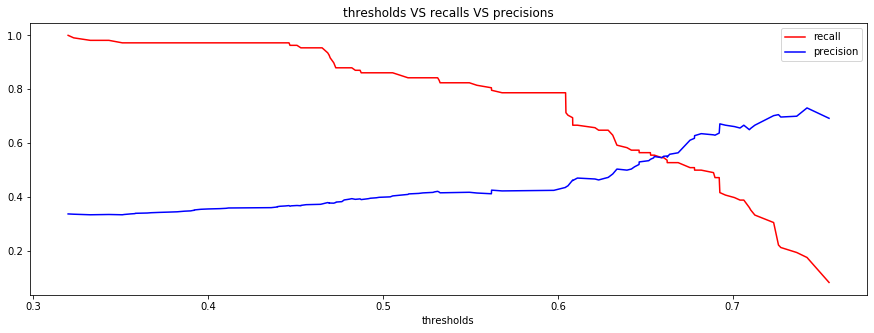

In [19]:
precision_recall_thresholds(y_val, y_prob)

In [20]:
loss_1 = []
loss_2 = []
precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)
for k in range(len(thresholds)):
    for i in range(len(y_prob)):
        if y_prob[i]>=thresholds[k]:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    scr = evaluate(y_val,y_pred, y_prob)
    diff_loss, total_loss = loss_point(num = group1_num, charge = group1_MC, tenure = group1_TN, sol_price = price, recall = scr[2], precision = scr[1])
    loss_1.append(diff_loss)
    loss_2.append(total_loss)
loss_1 = np.array(loss_1)
loss_2 = np.array(loss_2)

Accuracy : 0.446475
Precision : 0.337500
Recall : 1.000000
F1 score : 0.504673
F1.5 score : 0.623446
F2 score : 0.718085
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[108   0]
 [212  63]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 0.0만원
정밀도 오류에 따른 손해 : 27056.5만원
차이 : 27056.50000
Accuracy : 0.446475
Precision : 0.336478
Recall : 0.990741
F1 score : 0.502347
F1.5 score : 0.619875
F2 score : 0.713333
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[107   1]
 [211  64]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 725.89793만원
정밀도 오류에 따른 손해 : 27098.23899만원
차이 : 26372.34106
Accuracy : 0.443864
Precision : 0.334385
Recall : 0.981481
F1 score : 0.498824
F1.5 score : 0.615179
F2 score : 0.707610
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[106   2]
 [211  64]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 1451.79586만원
정밀도 오류에 따른 손해 : 27183.7224만원
차이 : 25731.92654
Accuracy : 0.446475
Precision : 0.335443
Recall : 0.9814

Accuracy : 0.522193
Precision : 0.367491
Recall : 0.962963
F1 score : 0.531969
F1.5 score : 0.642586
F2 score : 0.727273
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[104   4]
 [179  96]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 2903.59172만원
정밀도 오류에 따른 손해 : 25831.66078만원
차이 : 22928.06906
Accuracy : 0.524804
Precision : 0.368794
Recall : 0.962963
F1 score : 0.533333
F1.5 score : 0.643810
F2 score : 0.728291
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[104   4]
 [178  97]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 2903.59172만원
정밀도 오류에 따른 손해 : 25778.43972만원
차이 : 22874.84800
Accuracy : 0.524804
Precision : 0.367857
Recall : 0.953704
F1 score : 0.530928
F1.5 score : 0.640057
F2 score : 0.723315
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[103   5]
 [177  98]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 3629.48965만원
정밀도 오류에 따른 손해 : 25816.71429만원
차이 : 22187.22464
Accuracy : 0.527415
Precision : 0.369176
Re


Confusion Matrix : 
 [[ 91  17]
 [125 150]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 12340.2648만원
정밀도 오류에 따른 손해 : 23634.25926만원
차이 : 11293.99446
Accuracy : 0.626632
Precision : 0.418605
Recall : 0.833333
F1 score : 0.557276
F1.5 score : 0.638646
F2 score : 0.695518
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[ 90  18]
 [125 150]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 13066.16273만원
정밀도 오류에 따른 손해 : 23744.18605만원
차이 : 10678.02332
Accuracy : 0.624021
Precision : 0.415888
Recall : 0.824074
F1 score : 0.552795
F1.5 score : 0.632932
F2 score : 0.688854
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[ 89  19]
 [125 150]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 13792.06066만원
정밀도 오류에 따른 손해 : 23855.14019만원
차이 : 10063.07953
Accuracy : 0.626632
Precision : 0.417840
Recall : 0.824074
F1 score : 0.554517
F1.5 score : 0.634320
F2 score : 0.689922
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[ 89  19]
 [124 15

Accuracy : 0.744125
Precision : 0.546296
Recall : 0.546296
F1 score : 0.546296
F1.5 score : 0.546296
F2 score : 0.546296
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[ 59  49]
 [ 49 226]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 35568.99854만원
정밀도 오류에 따른 손해 : 18529.25926만원
차이 : 17039.73928만원
Accuracy : 0.746736
Precision : 0.551402
Recall : 0.546296
F1 score : 0.548837
F1.5 score : 0.547857
F2 score : 0.547310
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[ 59  49]
 [ 48 227]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 35568.99854만원
정밀도 오류에 따른 손해 : 18320.74766만원
차이 : 17248.25088만원
Accuracy : 0.746736
Precision : 0.552381
Recall : 0.537037
F1 score : 0.544601
F1.5 score : 0.541667
F2 score : 0.540037
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[ 58  50]
 [ 47 228]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 36294.89647만원
정밀도 오류에 따른 손해 : 18280.7619만원
차이 : 18014.13457만원
Accuracy : 0.744125
Precision : 0.5

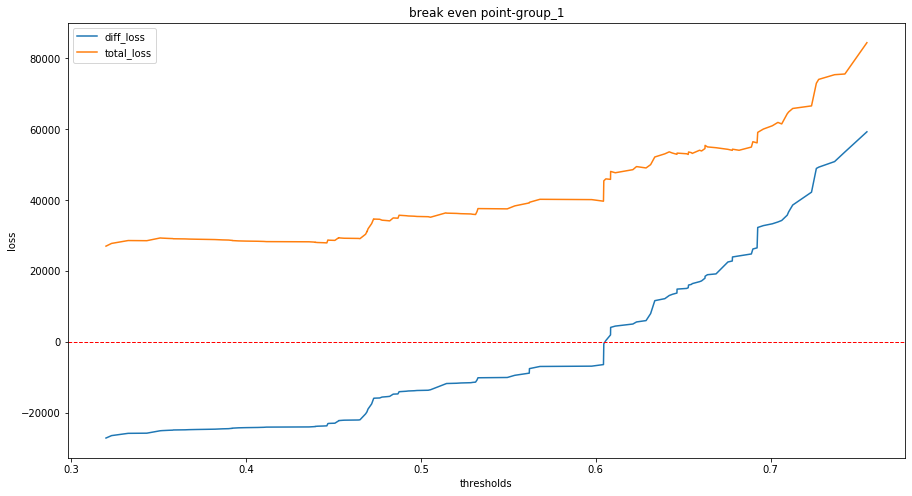

In [21]:
plt.figure(figsize=(15,8))
plt.title('break even point-group_1')
plt.xlabel('thresholds')
plt.ylabel('loss')
plt.plot(thresholds,loss_1, label = 'diff_loss')
plt.plot(thresholds,loss_2, label = 'total_loss')
plt.legend()
plt.axhline(y=0, color='r', linewidth=1, linestyle='--')

결론 : 집단 1에서는 재현율이 높을수록(그래프 왼쪽) 좋음, y=0인 지점이 마지노선(손익분기점)

#### 그룹 2 - 낮은 요금제 + 긴 임기

In [22]:
data = group_2.drop('Churn',axis=1)
target = group_2.Churn

seed = 77
X_train_val, X_test, y_train_val, y_test = train_test_split(data,target,random_state = seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val,random_state = seed)

param_grid = {'booster': ['gbtree'],
                  'objective' : ['binary:logistic'], 
                  'eval_metric' : ['error'],
                  'n_estimators':[100],
                  'max_depth': [3,5,7,9],
                  'min_child_weight':[1,3,5,7],
                  'learning_rate' : [0.01,0.05,0.1],
                  'scale_pos_weight':[1,3,5],
                  'colsample_bytree':[0.5,0.7,0.9]}

grid = GridSearchCV(estimator = xgb.XGBClassifier(), param_grid=param_grid, scoring='recall', verbose=1, n_jobs=-1, cv=5,)

grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 1376 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 1826 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  1.8min finished


Accuracy : 0.899254
Precision : 0.150000
Recall : 0.230769
F1 score : 0.181818
F1.5 score : 0.197970
F2 score : 0.208333
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[  3  10]
 [ 17 238]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 60305.36643만원
정밀도 오류에 따른 손해 : 34714.0만원
차이 : 25591.36643만원


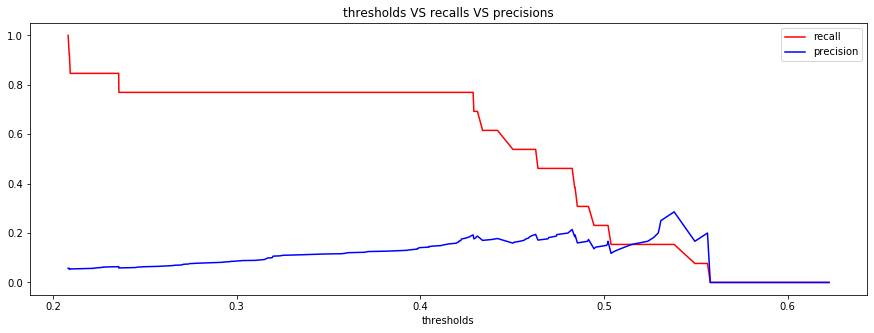

In [23]:
y_pred = grid_result.predict(X_val)

probs = grid_result.predict_proba(X_val)
y_prob = probs[:,1]

scr = evaluate(y_val,y_pred,y_prob)
loss_point(num = group1_num, charge = group1_MC, tenure = group1_TN, sol_price = price, recall = scr[2], precision = scr[1])
precision_recall_thresholds(y_val, y_prob)

In [24]:
loss_1 = []
loss_2 = []
precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)
for k in range(len(thresholds)):
    for i in range(len(y_prob)):
        if y_prob[i]>=thresholds[k]:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    scr = evaluate(y_val,y_pred, y_prob)
    diff_loss, total_loss = loss_point(num = group1_num, charge = group1_MC, tenure = group1_TN, sol_price = price, recall = scr[2], precision = scr[1])
    loss_1.append(diff_loss)
    loss_2.append(total_loss)
loss_1 = np.array(loss_1)
loss_2 = np.array(loss_2)

Accuracy : 0.205224
Precision : 0.057522
Recall : 1.000000
F1 score : 0.108787
F1.5 score : 0.165524
F2 score : 0.233813
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 13   0]
 [213  42]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 0.0만원
정밀도 오류에 따른 손해 : 38490.79646만원
차이 : 38490.79646
Accuracy : 0.216418
Precision : 0.054299
Recall : 0.923077
F1 score : 0.102564
F1.5 score : 0.155844
F2 score : 0.219780
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 12   1]
 [209  46]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 6030.53664만원
정밀도 오류에 따른 손해 : 38622.44344만원
차이 : 32591.90680
Accuracy : 0.261194
Precision : 0.057416
Recall : 0.923077
F1 score : 0.108108
F1.5 score : 0.163694
F2 score : 0.229885
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 12   1]
 [197  58]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 6030.53664만원
정밀도 오류에 따른 손해 : 38495.11962만원
차이 : 32464.58298
Accuracy : 0.272388
Precision : 0.053922
Recall : 

Accuracy : 0.444030
Precision : 0.064103
Recall : 0.769231
F1 score : 0.118343
F1.5 score : 0.175439
F2 score : 0.240385
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [146 109]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 38222.05128만원
차이 : 20130.44135
Accuracy : 0.447761
Precision : 0.064516
Recall : 0.769231
F1 score : 0.119048
F1.5 score : 0.176391
F2 score : 0.241546
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [145 110]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 38205.16129만원
차이 : 20113.55136
Accuracy : 0.451493
Precision : 0.064935
Recall : 0.769231
F1 score : 0.119760
F1.5 score : 0.177353
F2 score : 0.242718
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [144 111]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 38188.05195만원
차이 : 20096.44202
Accuracy : 0.455224
Precision : 0.065359


Confusion Matrix : 
 [[ 10   3]
 [112 143]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 37492.45902만원
차이 : 19400.84909
Accuracy : 0.574627
Precision : 0.082645
Recall : 0.769231
F1 score : 0.149254
F1.5 score : 0.216306
F2 score : 0.289017
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [111 144]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 37464.79339만원
차이 : 19373.18346
Accuracy : 0.578358
Precision : 0.083333
Recall : 0.769231
F1 score : 0.150376
F1.5 score : 0.217755
F2 score : 0.290698
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [110 145]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 37436.66667만원
차이 : 19345.05674
Accuracy : 0.582090
Precision : 0.084034
Recall : 0.769231
F1 score : 0.151515
F1.5 score : 0.219224
F2 score : 0.292398
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [109 1


Confusion Matrix : 
 [[ 10   3]
 [ 64 191]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 35321.08108만원
차이 : 17229.47115
Accuracy : 0.753731
Precision : 0.136986
Recall : 0.769231
F1 score : 0.232558
F1.5 score : 0.317848
F2 score : 0.400000
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [ 63 192]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 35245.47945만원
차이 : 17153.86952
Accuracy : 0.761194
Precision : 0.140845
Recall : 0.769231
F1 score : 0.238095
F1.5 score : 0.324190
F2 score : 0.406504
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [ 61 194]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 35087.88732만원
차이 : 16996.27739
Accuracy : 0.764925
Precision : 0.142857
Recall : 0.769231
F1 score : 0.240964
F1.5 score : 0.327456
F2 score : 0.409836
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [ 60 1

Accuracy : 0.858209
Precision : 0.179487
Recall : 0.538462
F1 score : 0.269231
F1.5 score : 0.333333
F2 score : 0.384615
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[  7   6]
 [ 32 223]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 36183.21986만원
정밀도 오류에 따른 손해 : 33509.74359만원
차이 : 2673.47627만원
Accuracy : 0.861940
Precision : 0.184211
Recall : 0.538462
F1 score : 0.274510
F1.5 score : 0.338290
F2 score : 0.388889
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[  7   6]
 [ 31 224]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 36183.21986만원
정밀도 오류에 따른 손해 : 33316.84211만원
차이 : 2866.37775만원
Accuracy : 0.865672
Precision : 0.189189
Recall : 0.538462
F1 score : 0.280000
F1.5 score : 0.343396
F2 score : 0.393258
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[  7   6]
 [ 30 225]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 36183.21986만원
정밀도 오류에 따른 손해 : 33113.51351만원
차이 : 3069.70635만원
Accuracy : 0.869403
Precision : 0.194

Accuracy : 0.940299
Precision : 0.285714
Recall : 0.153846
F1 score : 0.200000
F1.5 score : 0.179310
F2 score : 0.169492
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[  2  11]
 [  5 250]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 66335.90308만원
정밀도 오류에 따른 손해 : 29171.42857만원
차이 : 37164.47451만원
Accuracy : 0.936567
Precision : 0.166667
Recall : 0.076923
F1 score : 0.105263
F1.5 score : 0.092199
F2 score : 0.086207
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[  1  12]
 [  5 250]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 72366.43972만원
정밀도 오류에 따른 손해 : 34033.33333만원
차이 : 38333.10639만원
Accuracy : 0.940299
Precision : 0.200000
Recall : 0.076923
F1 score : 0.111111
F1.5 score : 0.094891
F2 score : 0.087719
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[  1  12]
 [  4 251]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 72366.43972만원
정밀도 오류에 따른 손해 : 32672.0만원
차이 : 39694.43972만원
Accuracy : 0.940299
Precision : 0.0000

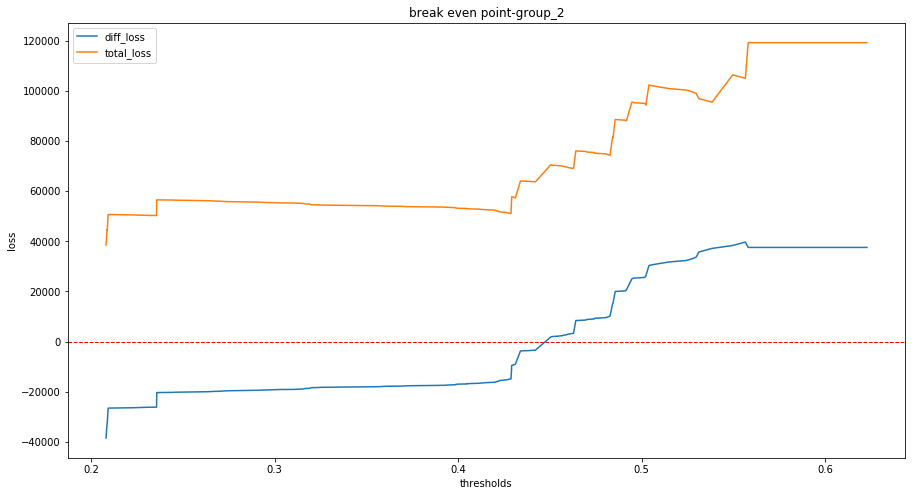

In [25]:
plt.figure(figsize=(15,8))
plt.title('break even point-group_2')
plt.xlabel('thresholds')
plt.ylabel('loss')
plt.plot(thresholds,loss_1, label = 'diff_loss')
plt.plot(thresholds,loss_2, label = 'total_loss')
plt.legend()
plt.axhline(y=0, color='r', linewidth=1, linestyle='--')

결론 : 집단 2에서는 재현율이 높을수록(그래프 왼쪽) 좋음, y=0인 지점이 마지노선(손익분기점)

#### 그룹 3 - 높은 요금제 + 짧은 임기

In [26]:
data = group_3.drop('Churn',axis=1)
target = group_3.Churn

seed = 77
X_train_val, X_test, y_train_val, y_test = train_test_split(data,target,random_state = seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val,random_state = seed)

param_grid = {'booster': ['gbtree'],
                  'objective' : ['binary:logistic'], 
                  'eval_metric' : ['error'],
                  'n_estimators':[100],
                  'max_depth': [3,5,7,9],
                  'min_child_weight':[1,3,5,7],
                  'learning_rate' : [0.01,0.05,0.1],
                  'scale_pos_weight':[1,3,5],
                  'colsample_bytree':[0.5,0.7,0.9]}

grid = GridSearchCV(estimator = xgb.XGBClassifier(), param_grid=param_grid, scoring='recall', verbose=1, n_jobs=-1, cv=5,)

grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 1256 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 1706 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  1.8min finished


Accuracy : 0.533333
Precision : 0.526923
Recall : 0.978571
F1 score : 0.685000
F1.5 score : 0.774348
F2 score : 0.835366
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[137   3]
 [123   7]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 1679.93521만원
정밀도 오류에 따른 손해 : 19320.46154만원
차이 : 17640.52633


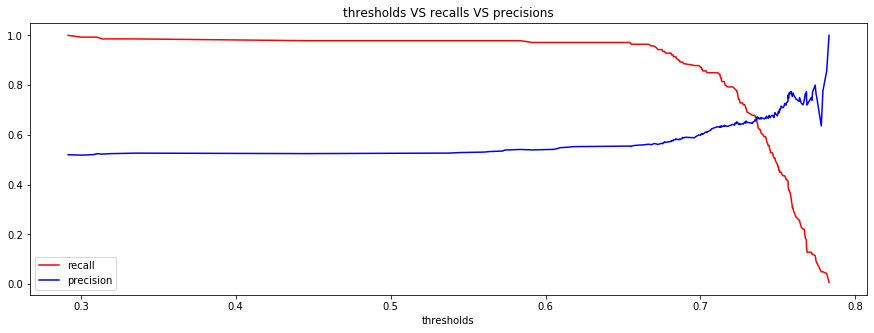

In [27]:
y_pred = grid_result.predict(X_val)

probs = grid_result.predict_proba(X_val)
y_prob = probs[:,1]

scr = evaluate(y_val,y_pred,y_prob)
loss_point(num = group1_num, charge = group1_MC, tenure = group1_TN, sol_price = price, recall = scr[2], precision = scr[1])
precision_recall_thresholds(y_val, y_prob)

In [28]:
loss_1 = []
loss_2 = []
precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)
for k in range(len(thresholds)):
    for i in range(len(y_prob)):
        if y_prob[i]>=thresholds[k]:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    scr = evaluate(y_val,y_pred, y_prob)
    diff_loss, total_loss = loss_point(num = group1_num, charge = group1_MC, tenure = group1_TN, sol_price = price, recall = scr[2], precision = scr[1])
    loss_1.append(diff_loss)
    loss_2.append(total_loss)
loss_1 = np.array(loss_1)
loss_2 = np.array(loss_2)

Accuracy : 0.522222
Precision : 0.520446
Recall : 1.000000
F1 score : 0.684597
F1.5 score : 0.779110
F2 score : 0.844391
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[140   0]
 [129   1]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 0.0만원
정밀도 오류에 따른 손해 : 19584.98141만원
차이 : 19584.98141
Accuracy : 0.518519
Precision : 0.518657
Recall : 0.992857
F1 score : 0.681373
F1.5 score : 0.774871
F2 score : 0.839372
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[139   1]
 [129   1]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 559.9784만원
정밀도 오류에 따른 손해 : 19658.0597만원
차이 : 19098.08130
Accuracy : 0.522222
Precision : 0.520599
Recall : 0.992857
F1 score : 0.683047
F1.5 score : 0.776203
F2 score : 0.840387
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[139   1]
 [128   2]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 559.9784만원
정밀도 오류에 따른 손해 : 19578.72659만원
차이 : 19018.74819
Accuracy : 0.525926
Precision : 0.522556
Recall : 0.992


Confusion Matrix : 
 [[135   5]
 [107  23]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 2799.89201만원
정밀도 오류에 따른 손해 : 18057.35537만원
차이 : 15257.46336
Accuracy : 0.588889
Precision : 0.560166
Recall : 0.964286
F1 score : 0.708661
F1.5 score : 0.789119
F2 score : 0.842697
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[135   5]
 [106  24]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 2799.89201만원
정밀도 오류에 따른 손해 : 17962.82158만원
차이 : 15162.92957
Accuracy : 0.592593
Precision : 0.562500
Recall : 0.964286
F1 score : 0.710526
F1.5 score : 0.790541
F2 score : 0.843750
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[135   5]
 [105  25]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 2799.89201만원
정밀도 오류에 따른 손해 : 17867.5만원
차이 : 15067.60799
Accuracy : 0.588889
Precision : 0.560669
Recall : 0.957143
F1 score : 0.707124
F1.5 score : 0.786101
F2 score : 0.838548
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[134   6]
 [105  25]]
정밀

Accuracy : 0.622222
Precision : 0.591346
Recall : 0.878571
F1 score : 0.706897
F1.5 score : 0.764340
F2 score : 0.800781
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[123  17]
 [ 85  45]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 9519.63284만원
정밀도 오류에 따른 손해 : 16689.42308만원
차이 : 7169.79024
Accuracy : 0.625926
Precision : 0.594203
Recall : 0.878571
F1 score : 0.708934
F1.5 score : 0.765805
F2 score : 0.801825
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[123  17]
 [ 84  46]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 9519.63284만원
정밀도 오류에 따른 손해 : 16572.75362만원
차이 : 7053.12078
Accuracy : 0.629630
Precision : 0.597087
Recall : 0.878571
F1 score : 0.710983
F1.5 score : 0.767274
F2 score : 0.802872
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[123  17]
 [ 83  47]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 9519.63284만원
정밀도 오류에 따른 손해 : 16454.95146만원
차이 : 6935.31862
Accuracy : 0.633333
Precision : 0.600000
Recal


Confusion Matrix : 
 [[111  29]
 [ 64  66]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 16239.37368만원
정밀도 오류에 따른 손해 : 14935.77143만원
차이 : 1303.60225만원
Accuracy : 0.659259
Precision : 0.637931
Recall : 0.792857
F1 score : 0.707006
F1.5 score : 0.737730
F2 score : 0.756131
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[111  29]
 [ 63  67]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 16239.37368만원
정밀도 오류에 따른 손해 : 14786.89655만원
차이 : 1452.47713만원
Accuracy : 0.662963
Precision : 0.641618
Recall : 0.792857
F1 score : 0.709265
F1.5 score : 0.739242
F2 score : 0.757162
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[111  29]
 [ 62  68]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 16239.37368만원
정밀도 오류에 따른 손해 : 14636.30058만원
차이 : 1603.07310만원
Accuracy : 0.659259
Precision : 0.639535
Recall : 0.785714
F1 score : 0.705128
F1.5 score : 0.734086
F2 score : 0.751366
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[110  30]
 [ 6

Accuracy : 0.655556
Precision : 0.671533
Recall : 0.657143
F1 score : 0.664260
F1.5 score : 0.661504
F2 score : 0.659971
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[92 48]
 [45 85]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 26878.96332만원
정밀도 오류에 따른 손해 : 13414.59854만원
차이 : 13464.36478만원
Accuracy : 0.648148
Precision : 0.666667
Recall : 0.642857
F1 score : 0.654545
F1.5 score : 0.650000
F2 score : 0.647482
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[90 50]
 [45 85]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 27998.92013만원
정밀도 오류에 따른 손해 : 13613.33333만원
차이 : 14385.58680만원
Accuracy : 0.651852
Precision : 0.671642
Recall : 0.642857
F1 score : 0.656934
F1.5 score : 0.651448
F2 score : 0.648415
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[90 50]
 [44 86]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 27998.92013만원
정밀도 오류에 따른 손해 : 13410.14925만원
차이 : 14588.77088만원
Accuracy : 0.644444
Precision : 0.666667
Recal

Accuracy : 0.611111
Precision : 0.676768
Recall : 0.478571
F1 score : 0.560669
F1.5 score : 0.525966
F2 score : 0.508346
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[67 73]
 [32 98]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 40878.42339만원
정밀도 오류에 따른 손해 : 13200.80808만원
차이 : 27677.61531만원
Accuracy : 0.614815
Precision : 0.683673
Recall : 0.478571
F1 score : 0.563025
F1.5 score : 0.527240
F2 score : 0.509119
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[67 73]
 [31 99]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 40878.42339만원
정밀도 오류에 따른 손해 : 12918.77551만원
차이 : 27959.64788만원
Accuracy : 0.614815
Precision : 0.687500
Recall : 0.471429
F1 score : 0.559322
F1.5 score : 0.521898
F2 score : 0.503049
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[ 66  74]
 [ 30 100]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 41438.40179만원
정밀도 오류에 따른 손해 : 12762.5만원
차이 : 28675.90179만원
Accuracy : 0.618519
Precision : 0.694737
Recal

Accuracy : 0.592593
Precision : 0.767857
Recall : 0.307143
F1 score : 0.438776
F1.5 score : 0.376685
F2 score : 0.349026
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[ 43  97]
 [ 13 117]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 54317.90505만원
정밀도 오류에 따른 손해 : 9480.71429만원
차이 : 44837.19076만원
Accuracy : 0.588889
Precision : 0.763636
Recall : 0.300000
F1 score : 0.430769
F1.5 score : 0.368919
F2 score : 0.341463
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[ 42  98]
 [ 13 117]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 54877.88346만원
정밀도 오류에 따른 손해 : 9653.09091만원
차이 : 45224.79255만원
Accuracy : 0.585185
Precision : 0.759259
Recall : 0.292857
F1 score : 0.422680
F1.5 score : 0.361111
F2 score : 0.333876
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[ 41  99]
 [ 13 117]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 55437.86186만원
정밀도 오류에 따른 손해 : 9831.85185만원
차이 : 45606.01001만원
Accuracy : 0.577778
Precision : 0.750

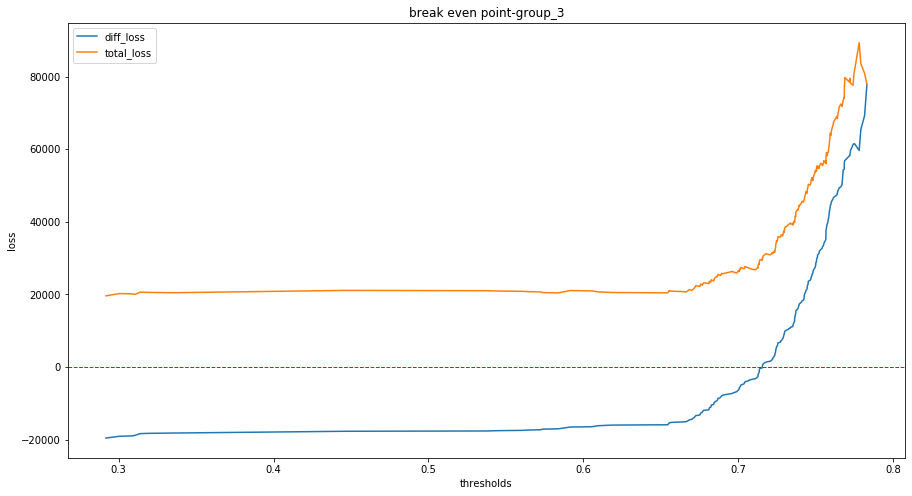

In [29]:
plt.figure(figsize=(15,8))
plt.title('break even point-group_3')
plt.xlabel('thresholds')
plt.ylabel('loss')
plt.plot(thresholds,loss_1, label = 'diff_loss')
plt.plot(thresholds,loss_2, label = 'total_loss')
plt.legend()
plt.axhline(y=0, color='r', linewidth=1, linestyle='--')

결론 : 집단 3에서는 재현율이 높을수록(그래프 왼쪽) 좋음, y=0인 지점이 마지노선(손익분기점)

#### 그룹 4 - 높은 요금제 + 긴 임기

In [30]:
data = group_4.drop('Churn',axis=1)
target = group_4.Churn

seed = 77
X_train_val, X_test, y_train_val, y_test = train_test_split(data,target,random_state = seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val,random_state = seed)

param_grid = {'booster': ['gbtree'],
                  'objective' : ['binary:logistic'], 
                  'eval_metric' : ['error'],
                  'n_estimators':[100],
                  'max_depth': [3,5,7,9],
                  'min_child_weight':[1,3,5,7],
                  'learning_rate' : [0.01,0.05,0.1],
                  'scale_pos_weight':[1,3,5],
                  'colsample_bytree':[0.5,0.7,0.9]}

grid = GridSearchCV(estimator = xgb.XGBClassifier(), param_grid=param_grid, scoring='recall', verbose=1, n_jobs=-1, cv=5,)

grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  2.5min finished


Accuracy : 0.631854
Precision : 0.348958
Recall : 0.807229
F1 score : 0.487273
F1.5 score : 0.574917
F2 score : 0.639313
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 67  16]
 [125 175]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 15112.67014만원
정밀도 오류에 따른 손해 : 26588.54167만원
차이 : 11475.87153


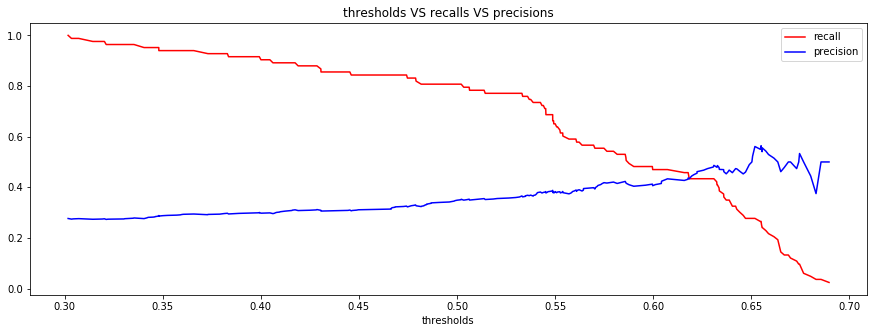

In [31]:
y_pred = grid_result.predict(X_val)

probs = grid_result.predict_proba(X_val)
y_prob = probs[:,1]

scr = evaluate(y_val,y_pred,y_prob)
loss_point(num = group1_num, charge = group1_MC, tenure = group1_TN, sol_price = price, recall = scr[2], precision = scr[1])
precision_recall_thresholds(y_val, y_prob)

In [32]:
loss_1 = []
loss_2 = []
precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)
for k in range(len(thresholds)):
    for i in range(len(y_prob)):
        if y_prob[i]>=thresholds[k]:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    scr = evaluate(y_val,y_pred, y_prob)
    diff_loss, total_loss = loss_point(num = group1_num, charge = group1_MC, tenure = group1_TN, sol_price = price, recall = scr[2], precision = scr[1])
    loss_1.append(diff_loss)
    loss_2.append(total_loss)
loss_1 = np.array(loss_1)
loss_2 = np.array(loss_2)

Accuracy : 0.433420
Precision : 0.276667
Recall : 1.000000
F1 score : 0.433420
F1.5 score : 0.554186
F2 score : 0.656646
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 83   0]
 [217  83]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 0.0만원
정밀도 오류에 따른 손해 : 29540.93333만원
차이 : 29540.93333
Accuracy : 0.430809
Precision : 0.274247
Recall : 0.987952
F1 score : 0.429319
F1.5 score : 0.548636
F2 score : 0.649762
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 82   1]
 [217  83]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 944.54188만원
정밀도 오류에 따른 손해 : 29639.73244만원
차이 : 28695.19056
Accuracy : 0.433420
Precision : 0.275168
Recall : 0.987952
F1 score : 0.430446
F1.5 score : 0.549768
F2 score : 0.650794
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 82   1]
 [216  84]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 944.54188만원
정밀도 오류에 따른 손해 : 29602.14765만원
차이 : 28657.60577
Accuracy : 0.436031
Precision : 0.276094
Recall : 0.


Confusion Matrix : 
 [[ 77   6]
 [187 113]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 5667.2513만원
정밀도 오류에 따른 손해 : 28928.33333만원
차이 : 23261.08203
Accuracy : 0.498695
Precision : 0.292776
Recall : 0.927711
F1 score : 0.445087
F1.5 score : 0.556420
F2 score : 0.647059
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 77   6]
 [186 114]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 5667.2513만원
정밀도 오류에 따른 손해 : 28883.04183만원
차이 : 23215.79053
Accuracy : 0.501305
Precision : 0.293893
Recall : 0.927711
F1 score : 0.446377
F1.5 score : 0.557660
F2 score : 0.648148
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 77   6]
 [185 115]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 5667.2513만원
정밀도 오류에 따른 손해 : 28837.40458만원
차이 : 23170.15328
Accuracy : 0.503916
Precision : 0.295019
Recall : 0.927711
F1 score : 0.447674
F1.5 score : 0.558906
F2 score : 0.649241
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 77   6]
 [184 116]]
정

Accuracy : 0.558747
Precision : 0.309735
Recall : 0.843373
F1 score : 0.453074
F1.5 score : 0.551181
F2 score : 0.627240
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 70  13]
 [156 144]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 12279.04449만원
정밀도 오류에 따른 손해 : 28190.44248만원
차이 : 15911.39799
Accuracy : 0.561358
Precision : 0.311111
Recall : 0.843373
F1 score : 0.454545
F1.5 score : 0.552520
F2 score : 0.628366
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 70  13]
 [155 145]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 12279.04449만원
정밀도 오류에 따른 손해 : 28134.22222만원
차이 : 15855.17773
Accuracy : 0.563969
Precision : 0.312500
Recall : 0.843373
F1 score : 0.456026
F1.5 score : 0.553865
F2 score : 0.629496
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 70  13]
 [154 146]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 12279.04449만원
정밀도 오류에 따른 손해 : 28077.5만원
차이 : 15798.45551
Accuracy : 0.566580
Precision : 0.313901
Rec

Accuracy : 0.642298
Precision : 0.353261
Recall : 0.783133
F1 score : 0.486891
F1.5 score : 0.569791
F2 score : 0.629845
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 65  18]
 [119 181]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 17001.75391만원
정밀도 오류에 따른 손해 : 26412.82609만원
차이 : 9411.07218
Accuracy : 0.644909
Precision : 0.355191
Recall : 0.783133
F1 score : 0.488722
F1.5 score : 0.571332
F2 score : 0.631068
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 65  18]
 [118 182]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 17001.75391만원
정밀도 오류에 따른 손해 : 26333.98907만원
차이 : 9332.23516
Accuracy : 0.642298
Precision : 0.351648
Recall : 0.771084
F1 score : 0.483019
F1.5 score : 0.564068
F2 score : 0.622568
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 64  19]
 [118 182]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 17946.29579만원
정밀도 오류에 따른 손해 : 26478.68132만원
차이 : 8532.38553
Accuracy : 0.644909
Precision : 0.353591
Re

ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 57  26]
 [ 94 206]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 24558.08898만원
정밀도 오류에 따른 손해 : 25423.57616만원
차이 : 865.48718
Accuracy : 0.689295
Precision : 0.380000
Recall : 0.686747
F1 score : 0.489270
F1.5 score : 0.550111
F2 score : 0.591286
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 57  26]
 [ 93 207]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 24558.08898만원
정밀도 오류에 따른 손해 : 25320.8만원
차이 : 762.71102
Accuracy : 0.691906
Precision : 0.382550
Recall : 0.686747
F1 score : 0.491379
F1.5 score : 0.551750
F2 score : 0.592516
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 57  26]
 [ 92 208]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 24558.08898만원
정밀도 오류에 따른 손해 : 25216.6443만원
차이 : 658.55532
Accuracy : 0.694517
Precision : 0.385135
Recall : 0.686747
F1 score : 0.493506
F1.5 score : 0.553398
F2 score : 0.593750
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 


Confusion Matrix : 
 [[ 46  37]
 [ 68 232]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 34948.0497만원
정밀도 오류에 따른 손해 : 24360.70175만원
차이 : 10587.34795만원
Accuracy : 0.728460
Precision : 0.407080
Recall : 0.554217
F1 score : 0.469388
F1.5 score : 0.498749
F2 score : 0.516854
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 46  37]
 [ 67 233]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 34948.0497만원
정밀도 오류에 따른 손해 : 24214.86726만원
차이 : 10733.18244만원
Accuracy : 0.731070
Precision : 0.410714
Recall : 0.554217
F1 score : 0.471795
F1.5 score : 0.500418
F2 score : 0.518018
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 46  37]
 [ 66 234]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 34948.0497만원
정밀도 오류에 따른 손해 : 24066.42857만원
차이 : 10881.62113만원
Accuracy : 0.733681
Precision : 0.414414
Recall : 0.554217
F1 score : 0.474227
F1.5 score : 0.502099
F2 score : 0.519187
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 46  37]
 [ 6


Confusion Matrix : 
 [[ 33  50]
 [ 36 264]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 47227.0942만원
정밀도 오류에 따른 손해 : 21307.82609만원
차이 : 25919.26811만원
Accuracy : 0.772846
Precision : 0.470588
Recall : 0.385542
F1 score : 0.423841
F1.5 score : 0.408243
F2 score : 0.400000
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 32  51]
 [ 36 264]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 48171.63608만원
정밀도 오류에 따른 손해 : 21621.17647만원
차이 : 26550.45961만원
Accuracy : 0.772846
Precision : 0.469697
Recall : 0.373494
F1 score : 0.416107
F1.5 score : 0.398615
F2 score : 0.389447
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 31  52]
 [ 35 265]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 49116.17796만원
정밀도 오류에 따른 손해 : 21657.57576만원
차이 : 27458.60220만원
Accuracy : 0.770235
Precision : 0.461538
Recall : 0.361446
F1 score : 0.405405
F1.5 score : 0.387289
F2 score : 0.377834
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 30  53]
 [


Confusion Matrix : 
 [[  3  80]
 [  5 295]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 75563.35071만원
정밀도 오류에 따른 손해 : 25525.0만원
차이 : 50038.35071만원
Accuracy : 0.783290
Precision : 0.500000
Recall : 0.036145
F1 score : 0.067416
F1.5 score : 0.050584
F2 score : 0.044379
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[  3  80]
 [  3 297]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 75563.35071만원
정밀도 오류에 따른 손해 : 20420.0만원
차이 : 55143.35071만원
Accuracy : 0.783290
Precision : 0.500000
Recall : 0.024096
F1 score : 0.045977
F1.5 score : 0.034076
F2 score : 0.029762
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[  2  81]
 [  2 298]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 76507.8926만원
정밀도 오류에 따른 손해 : 20420.0만원
차이 : 56087.89260만원


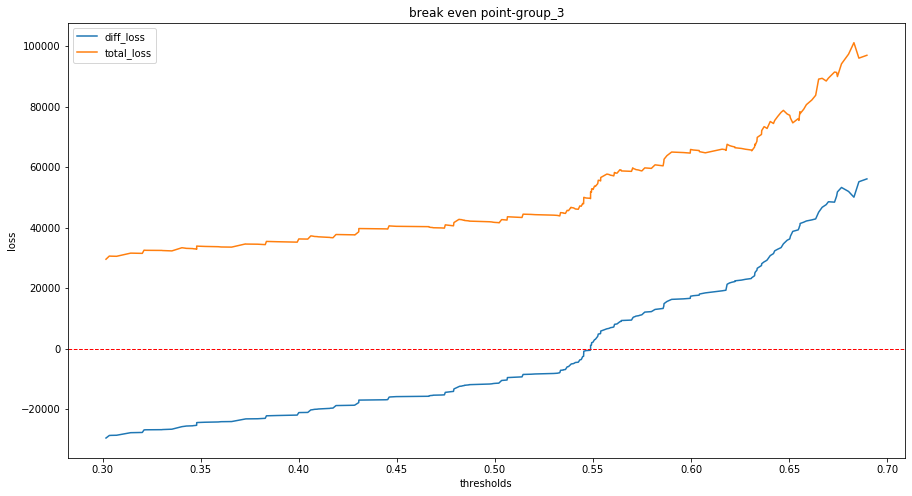

In [33]:
plt.figure(figsize=(15,8))
plt.title('break even point-group_3')
plt.xlabel('thresholds')
plt.ylabel('loss')
plt.plot(thresholds,loss_1, label = 'diff_loss')
plt.plot(thresholds,loss_2, label = 'total_loss')
plt.legend()
plt.axhline(y=0, color='r', linewidth=1, linestyle='--')

결론 : 집단 2에서는 재현율이 높을수록(그래프 왼쪽) 좋음, y=0인 지점이 마지노선(손익분기점)

최종 결론
손익분기점의 요소들을 내가 임의적으로 설정해서 그런지, 모든 그룹에서 재현율이 무작정 높기만 한 것이 무조건 좋게 나왔다.